# Before you begin
Use the GPU, it reduces runtime from 1 hour to 3-5 minutes max.
To do so:
1. Click Runtime
2. Click Change Runtime type
3. For Hardware Accelerator, click GPU.
4. Click save

Instead of making new notebooks for every crop, just make some of the changes required and save the models and then start again for the new model. There is no need to have different notebooks.

# How to improve accuracy
1. Data Cleaning. Only keep photos of close ups of the vegetable. Delete diagrams and photos where the whole field has been photographed. If 2 diseases look alike- then combine them and rename them. For example, if pink rot and brown rot have similar symptoms, combine them to rot.

2. Data augmentation to make up for the small datasets.

### Things that have to be changed are written as text above the cell.

> 1. In the right side, select files, upload a zip file of the relevant crop.
2. Change Tomato.zip to [yourname].zip
3. Run the cell.



> If you are using google drive, run this cell and then copy the path of the zip file in your google drive and put it after !unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip /content/drive/MyDrive/temp/Dataset/Fruits.zip

Archive:  /content/drive/MyDrive/temp/Dataset/Vegetables.zip
   creating: Vegetables/
   creating: Vegetables/Blight/
  inflating: Vegetables/Blight/100_46341.jpg  
  inflating: Vegetables/Blight/1058_0.jpeg_itok=OQkdtxgv.jpg  
  inflating: Vegetables/Blight/118A_Tom_Late.jpg  
  inflating: Vegetables/Blight/126689-004-D622CD2F.jpg  
  inflating: Vegetables/Blight/12July_mwnews_3-C.jpg  
  inflating: Vegetables/Blight/1576389-early%20blight%20symptoms.jpg  
  inflating: Vegetables/Blight/20020531-early%20blight%20%20starts%20on%20lower%20leaves.jpg  
  inflating: Vegetables/Blight/20080526-_DSC4211.jpg  
  inflating: Vegetables/Blight/20150619d.jpg  
  inflating: Vegetables/Blight/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1.jpg  
  inflating: Vegetables/Blight/2373320.jpg  
  inflating: Vegetables/Blight/30053_original.jpg  
  inflating: Vegetables/Blight/3606630.jpg  
  inflating: Vegetables/Blight/5086-early.jpg  
 extracting: Vegetables/Blight/5816170621_e1cce08736_z.jpg  
  inf

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


> 1. Once the file has been unzipped, we split it using splitfolders. Here 'Tomato' is the name of the unzipped folder. Replace it with [yourname].
2. Once split, it has to go to 'output/[yourname]'. So change the name here accordingly as well.



In [ ]:
import splitfolders
splitfolders.ratio('Vegetables', output="output/Vegetables", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 3314 files [00:00, 5542.88 files/s]


> 1. You only need to replace Tomato with [yourname]. So, it will look like 'output/[yourname]/train'. Do this for test and val as well.



In [ ]:
train_path = 'output/Vegetables/train'
val_path = 'output/Vegetables/val'
test_path = 'output/Vegetables/test'

In [ ]:
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# This is where the data augmentation has been done. You can change the numbers and see if accuracy changes.
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rotation_range=80,
                                 fill_mode='nearest',
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 brightness_range=[0.4,1.5],
                                 zoom_range=0.3,
                                 shear_range=0.2)

train_batches=train_datagen.flow_from_directory(train_path,
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, )
val_batches=val_datagen.flow_from_directory(val_path,
                                            target_size=IMG_SIZE,
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True)

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches=train_datagen.flow_from_directory(test_path,
                                                target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 2647 images belonging to 11 classes.
Found 326 images belonging to 11 classes.
Found 341 images belonging to 11 classes.


> **Take note of the number of classes in the output above.**



In [ ]:
classes = train_batches.class_indices
class_list = list(classes.keys())

In [ ]:
imgs, labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

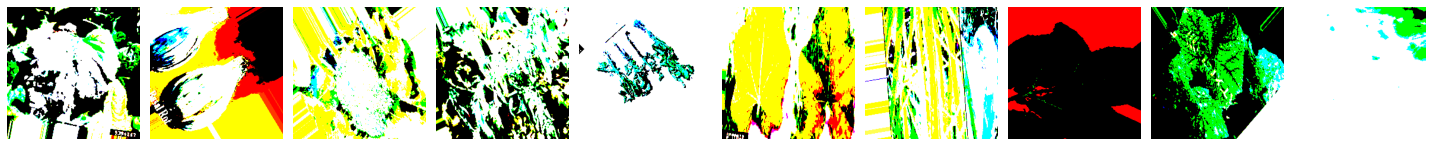

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.

In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
vgg16model = tf.keras.applications.vgg16.VGG16()
vgg16model.trainable = False

553476096/553467096 [==============================] - 2s 0us/step


In [ ]:
vgg16model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
for layer in vgg16model.layers[:-1]:
    model.add(layer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

> 1. Here, Change the number of units to whatever the number of classes was. Just change the number, nothing else.



In [ ]:
model.add(Dense(units=11, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# learning rate can be changed here.
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tqdm.keras import TqdmCallback

In [ ]:
# number of epochs can be changed here. Recommended to start between 10-15
model.fit(x=train_batches, validation_data=val_batches, epochs = 15, verbose = 0, callbacks=[TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

  0%|          | 0.00/83.0 [00:00<?, ?batch/s]

In [ ]:
prediction = model.predict(x=test_batches, verbose = 0)

In [ ]:
test_batches.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

In [ ]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(prediction, axis = -1))

In [ ]:
test_batches.class_indices

{'Blight': 0,
 'Club Root': 1,
 'Damping off': 2,
 'Downy Mildew': 3,
 'Fruit Rot': 4,
 'Iris Yellow Spot': 5,
 'Leaf Rot': 6,
 'Leaf Spot': 7,
 'Powdery Mildew': 8,
 'White Rust': 9,
 'Wilt': 10}

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

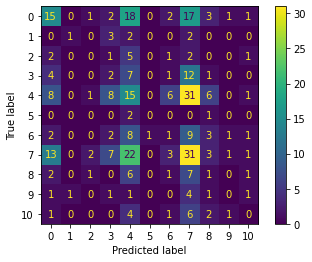

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true = test_batches.classes, y_pred = np.argmax(prediction, axis = -1), normalize=True, sample_weight=None) * 100

19.35483870967742

## ! Save the models till we come up with a better solution. Download the .h5 models and .json to your system because Colab deletes them as soon as you close it.

> Change Tomato.h5 to [yourname].h5. Both times. Do this for the next cell too if you are using google drive.

In [ ]:
#Saving model
from keras.models import load_model
model.save("Onion.h5")
loaded_model = load_model("Onion.h5")
loss, accuracy = loaded_model.evaluate(test_batches)

11/11 [==============================] - 6s 544ms/step - loss: 1.5026 - accuracy: 0.4692


In [ ]:
import shutil
shutil.copy("/content/Onion.h5","/content/drive/MyDrive/Vegetables.h5")

'/content/drive/MyDrive/Vegetables.h5'



---


*Run these cells only if you are using React and Node for production.*

*From here ⬇️*

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.7 MB/s 
     |████████████████████████████████| 40 kB 7.4 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


*Change Onion to [yourname] in both instances.*

In [ ]:
import tensorflowjs as tfjs
!tensorflowjs_converter --input_format keras 'Onion.h5' 'mnist-Onion'

In [ ]:
!zip -r /content/mnist-Onion.zip /content/mnist-Onion

  adding: content/mnist-Onion/ (stored 0%)
  adding: content/mnist-Onion/group1-shard56of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard44of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard88of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard106of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard74of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard93of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard96of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard7of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard38of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard53of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard100of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard22of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard67of129.bin (deflated 7%)
  adding: content/mnist-Onion/group1-shard116of129.bin (deflated 7%)
  a

In [ ]:
from google.colab import files
files.download("/content/mnist-Onion.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pathlib import Path
Path('/content/mnist-Onion.zip').stat().st_size

498320323

*Till here ⬆️*


---



> 1. Change all instances of Tomato to [yourname]. The extension remains the same.

In [ ]:
# Saving model structure to a JSON file
model_json = model.to_json()
with open("Tomato.json", "w") as json_file:
    json_file.write(model_json)

# Saving weights of the model to a HDF5 file
model.save_weights("Tomato.h5")

# Loading JSON file
json_file = open("Tomato.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Loading weights
loaded_model.load_weights("Tomato.h5")
loss, accuracy = loaded_model.evaluate(test_batches)

## Things that can be experimented with to increase accuracy
1. Change the number of epochs. Usually becomes redundant after some time but if the model is continuously imporving change the 15 to 40 or any other number.
2. In the data augmentation part, play with some of the numbers till accuracy improves. That part has been marked with a comment.
3. Changing the learning rate
4. Downloading higher quality data (does not always work)
5. Extensive data cleaning
6. Changing the optimizer